<a href="https://colab.research.google.com/github/rowii7/Projects/blob/main/BrainTumorDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import files
files.upload()

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d masoudnickparvar/brain-tumor-mri-dataset
!kaggle datasets download -d awsaf49/brain-tumor-dataset
!kaggle datasets download -d navoneel/brain-mri-images-for-brain-tumor-detection --force

import zipfile
import os


if os.path.exists("brain-tumor-mri-dataset.zip"):
    with zipfile.ZipFile("brain-tumor-mri-dataset.zip", 'r') as zip_ref:
        zip_ref.extractall("dataset_large")
else:
    print("brain-tumor-mri-dataset.zip not found.")


if os.path.exists("brain-mri-images-for-brain-tumor-detection.zip"):
    with zipfile.ZipFile("brain-mri-images-for-brain-tumor-detection.zip", 'r') as zip_ref:
        zip_ref.extractall("dataset_small")
else:
    print("brain-mri-images-for-brain-tumor-detection.zip not found.")

Saving kaggle.json to kaggle (4).json
Dataset URL: https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset
License(s): CC0-1.0
brain-tumor-mri-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)
403 Client Error: Forbidden for url: https://www.kaggle.com/api/v1/datasets/metadata/awsaf49/brain-tumor-dataset


In [ ]:
import os
import shutil

os.makedirs('combined_dataset/yes', exist_ok=True)
os.makedirs('combined_dataset/no', exist_ok=True)

small_base = 'dataset_small/brain_tumor_dataset'

for file in os.listdir(os.path.join(small_base, 'yes')):
    shutil.copy(os.path.join(small_base, 'yes', file), 'combined_dataset/yes')

for file in os.listdir(os.path.join(small_base, 'no')):
    shutil.copy(os.path.join(small_base, 'no', file), 'combined_dataset/no')


tumor_folders = [
    'dataset_large/Training/glioma',
    'dataset_large/Training/meningioma',
    'dataset_large/Training/pituitary',
    'dataset_large/Testing/glioma',
    'dataset_large/Testing/meningioma',
    'dataset_large/Testing/pituitary'
]

no_tumor_folders = [
    'dataset_large/Training/notumor',
    'dataset_large/Testing/notumor'
]

for folder in tumor_folders:
    for file in os.listdir(folder):
        shutil.copy(os.path.join(folder, file), 'combined_dataset/yes')

for folder in no_tumor_folders:
    for file in os.listdir(folder):
        shutil.copy(os.path.join(folder, file), 'combined_dataset/no')


In [ ]:
import os
import hashlib
from PIL import Image

def file_hash(filepath):
    """Compute MD5 hash of a file."""
    hasher = hashlib.md5()
    with open(filepath, 'rb') as f:
        buf = f.read()
        hasher.update(buf)
    return hasher.hexdigest()

def clean_dataset(dataset_path):
    for class_folder in ['yes', 'no']:
        folder_path = os.path.join(dataset_path, class_folder)
        hashes = set()
        to_delete = []

        for filename in os.listdir(folder_path):
            filepath = os.path.join(folder_path, filename)

            try:
                img = Image.open(filepath)
                img.verify()
            except Exception:
                print(f"Corrupted or unreadable file detected and will be deleted: {filepath}")
                to_delete.append(filepath)
                continue

            file_md5 = file_hash(filepath)
            if file_md5 in hashes:
                print(f"Duplicate file detected and will be deleted: {filepath}")
                to_delete.append(filepath)
            else:
                hashes.add(file_md5)

        for file_path in to_delete:
            os.remove(file_path)
            print(f"Deleted: {file_path}")

clean_dataset('combined_dataset')


Duplicate file detected and will be deleted: combined_dataset/yes/Tr-pi_0527.jpg
Duplicate file detected and will be deleted: combined_dataset/yes/Te-me_0010.jpg
Duplicate file detected and will be deleted: combined_dataset/yes/Tr-pi_0342.jpg
Duplicate file detected and will be deleted: combined_dataset/yes/Tr-pi_0227.jpg
Duplicate file detected and will be deleted: combined_dataset/yes/Te-me_0071.jpg
Duplicate file detected and will be deleted: combined_dataset/yes/Y108.jpg
Duplicate file detected and will be deleted: combined_dataset/yes/Te-piTr_0001.jpg
Duplicate file detected and will be deleted: combined_dataset/yes/Y30.jpg
Duplicate file detected and will be deleted: combined_dataset/yes/Tr-pi_0516.jpg
Duplicate file detected and will be deleted: combined_dataset/yes/Te-pi_0055.jpg
Duplicate file detected and will be deleted: combined_dataset/yes/Y14.jpg
Duplicate file detected and will be deleted: combined_dataset/yes/Te-gl_0029.jpg
Duplicate file detected and will be deleted: c

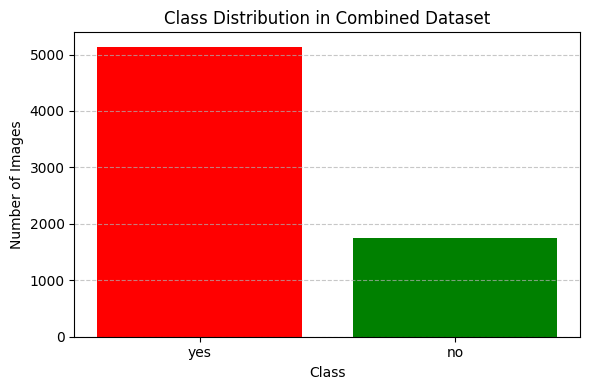

In [ ]:
import os
import matplotlib.pyplot as plt

data_path = 'combined_dataset'

class_counts = {
    'yes': len(os.listdir(os.path.join(data_path, 'yes'))),
    'no': len(os.listdir(os.path.join(data_path, 'no')))
}

plt.figure(figsize=(6, 4))
plt.bar(class_counts.keys(), class_counts.values(), color=['red', 'green'])
plt.title('Class Distribution in Combined Dataset')
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


In [ ]:

data_path = 'combined_dataset'

num_yes = len(os.listdir(os.path.join(data_path, 'yes')))
num_no = len(os.listdir(os.path.join(data_path, 'no')))

print(f"Number of images in class 'yes' (tumor): {num_yes}")
print(f"Number of images in class 'no' (no tumor): {num_no}")

Number of images in class 'yes' (tumor): 5136
Number of images in class 'no' (no tumor): 1757


In [ ]:
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, save_img

original_no_dir = 'combined_dataset/no'
augmented_no_dir = 'augmented_no'

os.makedirs(augmented_no_dir, exist_ok=True)

existing_count = len(os.listdir(original_no_dir))
target_count = 3500
needed = target_count - existing_count
print(f"Existing 'no' images: {existing_count}, need to generate: {needed}")

datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.05,
    height_shift_range=0.05,
    zoom_range=0.1,
    brightness_range=[0.9, 1.1],
    shear_range=0.05,
    fill_mode='nearest'
)

image_files = os.listdir(original_no_dir)

generated_count = 0
img_num = 0

while generated_count < needed:
    for img_file in image_files:
        img_path = os.path.join(original_no_dir, img_file)
        img = load_img(img_path)
        x = img_to_array(img)
        x = x.reshape((1,) + x.shape)


        aug_iter = datagen.flow(x, batch_size=1)

        aug_img = next(aug_iter)[0].astype('uint8')

        save_path = os.path.join(augmented_no_dir, f'aug_no_{img_num}.jpg')
        save_img(save_path, aug_img)

        img_num += 1
        generated_count += 1

        if generated_count >= needed:
            break

print(f"Augmentation complete! Total augmented images generated: {generated_count}")


Existing 'no' images: 1757, need to generate: 1743
Augmentation complete! Total augmented images generated: 1743


In [ ]:
import shutil

for f in os.listdir(augmented_no_dir):
    shutil.move(os.path.join(augmented_no_dir, f), original_no_dir)
print("Augmented images moved to combined_dataset/no")


Augmented images moved to combined_dataset/no


In [ ]:
import os
import random

yes_dir = 'combined_dataset/yes'
target_num = 3500

all_files = os.listdir(yes_dir)
current_num = len(all_files)

print(f"Current number of 'yes' images: {current_num}")

if current_num > target_num:

    files_to_keep = set(random.sample(all_files, target_num))


    for file in all_files:
        if file not in files_to_keep:
            os.remove(os.path.join(yes_dir, file))
    print(f"Downsampling done. Kept {target_num} images in 'yes' class.")
else:
    print("No downsampling needed, dataset already smaller than or equal to target.")


Current number of 'yes' images: 5136
Downsampling done. Kept 3500 images in 'yes' class.


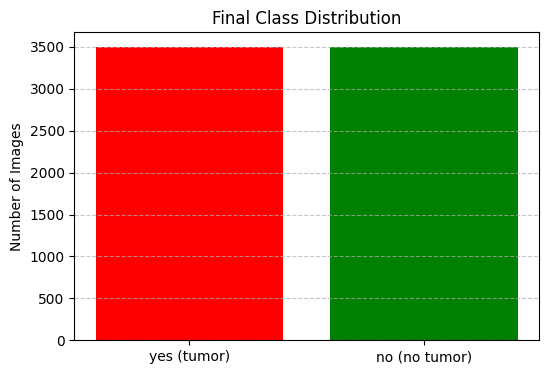

In [ ]:
import os
import matplotlib.pyplot as plt

data_path = 'combined_dataset'

num_yes = len(os.listdir(os.path.join(data_path, 'yes')))
num_no = len(os.listdir(os.path.join(data_path, 'no')))

plt.figure(figsize=(6,4))
plt.bar(['yes (tumor)', 'no (no tumor)'], [num_yes, num_no], color=['red', 'green'])
plt.title('Final Class Distribution')
plt.ylabel('Number of Images')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


In [ ]:
import os
from tensorflow.keras.preprocessing.image import load_img, img_to_array, save_img

def resize_images(source_dir, target_dir, target_size=(224, 224)):
    os.makedirs(target_dir, exist_ok=True)

    for cls in os.listdir(source_dir):
        class_path = os.path.join(source_dir, cls)
        if not os.path.isdir(class_path):
            continue

        target_class_path = os.path.join(target_dir, cls)
        os.makedirs(target_class_path, exist_ok=True)

        for img_name in os.listdir(class_path):
            img_path = os.path.join(class_path, img_name)
            try:
                img = load_img(img_path, target_size=target_size)
                save_img(os.path.join(target_class_path, img_name), img)
            except Exception as e:
                print(f"Error processing {img_path}: {e}")

resize_images('combined_dataset', 'combined_dataset_resized', target_size=(224, 224))


In [ ]:
import os
import shutil
import random

def split_data(source_dir, output_dir, train_ratio=0.7, val_ratio=0.15, test_ratio=0.15):
    os.makedirs(output_dir, exist_ok=True)
    for split in ['train', 'val', 'test']:
        os.makedirs(os.path.join(output_dir, split), exist_ok=True)

    classes = [d for d in os.listdir(source_dir) if os.path.isdir(os.path.join(source_dir, d))]

    for cls in classes:
        class_files = os.listdir(os.path.join(source_dir, cls))
        random.shuffle(class_files)

        n_total = len(class_files)
        n_train = int(n_total * train_ratio)
        n_val = int(n_total * val_ratio)

        splits = {
            'train': class_files[:n_train],
            'val': class_files[n_train:n_train+n_val],
            'test': class_files[n_train+n_val:]
        }

        for split, files in splits.items():
            split_class_dir = os.path.join(output_dir, split, cls)
            os.makedirs(split_class_dir, exist_ok=True)
            for f in files:
                shutil.copy(os.path.join(source_dir, cls, f), os.path.join(split_class_dir, f))

split_data('combined_dataset_resized', 'final_dataset_split')


In [ ]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet import preprocess_input
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

input_shape = (224, 224, 3)

base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)
base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
output = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=output)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_generator = train_datagen.flow_from_directory(
    'final_dataset_split/train',
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

val_generator = val_datagen.flow_from_directory(
    'final_dataset_split/val',
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)


history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10
)


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 23,850,113 (90.98 MB)

 Trainable params: 262,401 (1.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

Found 4900 images belonging to 2 classes.
Found 1050 images belonging to 2 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
154/154 ━━━━━━━━━━━━━━━━━━━━ 85s 463ms/step - accuracy: 0.8614 - loss: 0.3464 - val_accuracy: 0.9752 - val_loss: 0.0705
Epoch 2/10
154/154 ━━━━━━━━━━━━━━━━━━━━ 66s 407ms/step - accuracy: 0.9700 - loss: 0.0839 - val_accuracy: 0.9857 - val_loss: 0.0460
Epoch 3/10
154/154 ━━━━━━━━━━━━━━━━━━━━ 60s 390ms/step - accuracy: 0.9766 - loss: 0.0660 - val_accuracy: 0.9857 - val_loss: 0.0479
Epoch 4/10
154/154 ━━━━━━━━━━━━━━━━━━━━ 60s 391ms/step - accuracy: 0.9852 - loss: 0.0439 - val_accuracy: 0.9771 - val_loss: 0.0582
Epoch 5/10
154/154 ━━━━━━━━━━━━━━━━━━━━ 83s 399ms/step - accuracy: 0.9863 - loss: 0.0385 - val_accuracy: 0.9905 - val_loss: 0.0358
Epoch 6/10
154/154 ━━━━━━━━━━━━━━━━━━━━ 60s 392ms/step - accuracy: 0.9849 - loss: 0.0433 - val_accuracy: 0.9895 - val_loss: 0.0336
Epoch 7/10
154/154 ━━━━━━━━━━━━━━━━━━━━ 61s 395ms/step - accuracy: 0.9892 - loss: 0.0277 - val_accuracy: 0.9638 - val_loss: 0.0873
Epoch 8/10
154/154 ━━━━━━━━━━━━━━━━━━━━ 60s 392ms/step - accuracy: 0.9885 - loss: 0

Found 1050 images belonging to 2 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


33/33 ━━━━━━━━━━━━━━━━━━━━ 11s 209ms/step
Classification Report:

              precision    recall  f1-score   support

          no       0.97      1.00      0.98       525
         yes       1.00      0.97      0.98       525

    accuracy                           0.98      1050
   macro avg       0.99      0.98      0.98      1050
weighted avg       0.99      0.98      0.98      1050

Overall Accuracy: 0.9848


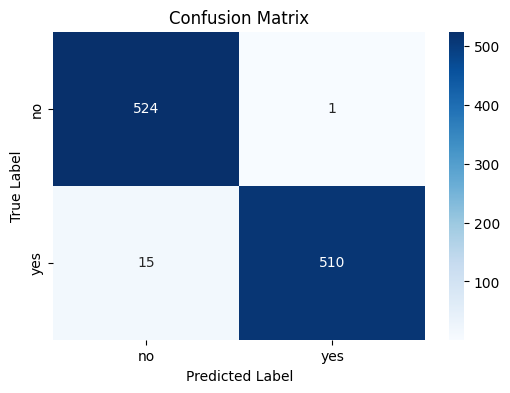

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

test_generator = test_datagen.flow_from_directory(
    'final_dataset_split/test',
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    shuffle=False
)

y_pred_prob = model.predict(test_generator)
y_pred = (y_pred_prob > 0.5).astype(int).reshape(-1)
y_true = test_generator.classes

class_labels = list(test_generator.class_indices.keys())

print("Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_labels))

accuracy = accuracy_score(y_true, y_pred)
print(f"Overall Accuracy: {accuracy:.4f}")


cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


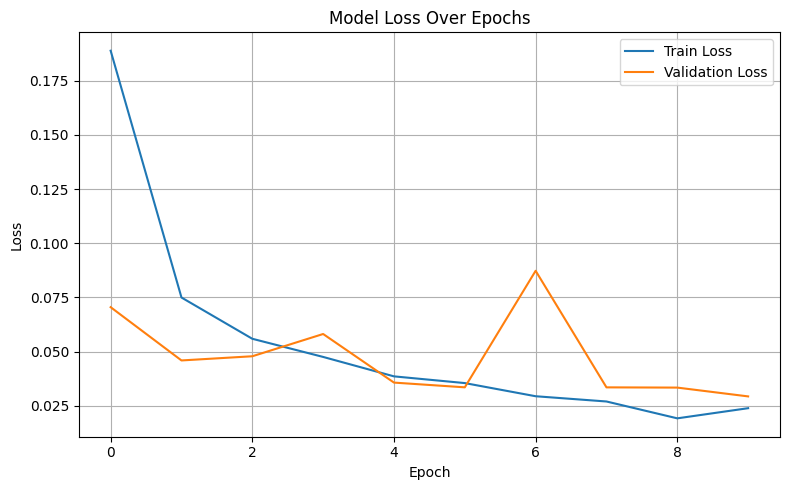

In [ ]:

plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


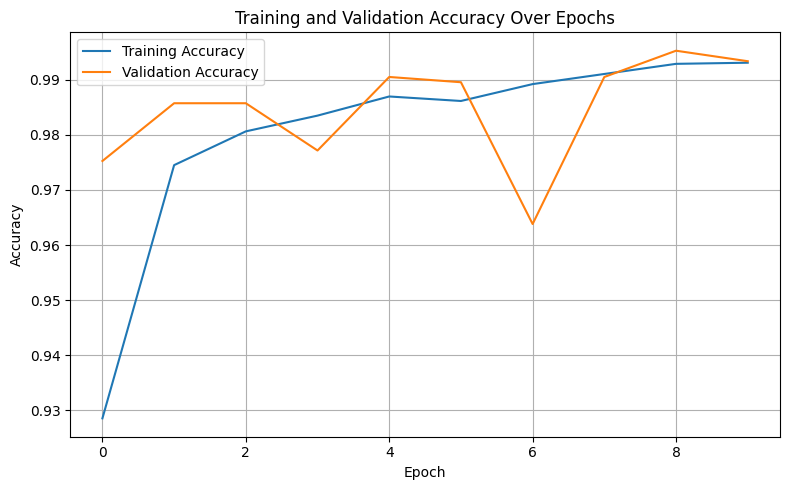

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
